In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Uber Lyft Prediction").getOrCreate()

In [2]:
df = spark.read.csv("rideshare_kaggle.csv", header=True, inferSchema=True)
df.show()

+--------------------+----------------+----+---+-----+-------------------+----------------+----------------+--------------------+--------+--------------------+------------+-----+--------+----------------+--------+---------+-----------+-------------------+---------------+--------------------+---------------+-----------------+--------+---------+--------+------------+----------+---------------+-------------------+--------------+------------------+-----------------------+---------------------------+----------------------+--------------------------+--------------------+--------+--------+-----------+----------+-------+------------+-----+-----------+----------+---------+------------------+-----------+--------------+------------------+--------------+------------------+----------------------+--------------------------+----------------------+--------------------------+
|                  id|       timestamp|hour|day|month|           datetime|        timezone|          source|         destination

In [3]:
df = df.select(['source','destination','price','distance','cab_type','name','surge_multiplier'])
df.show()

+----------------+--------------------+-----+--------+--------+------------+----------------+
|          source|         destination|price|distance|cab_type|        name|surge_multiplier|
+----------------+--------------------+-----+--------+--------+------------+----------------+
|Haymarket Square|       North Station|    5|    0.44|    Lyft|      Shared|             1.0|
|Haymarket Square|       North Station|   11|    0.44|    Lyft|         Lux|             1.0|
|Haymarket Square|       North Station|    7|    0.44|    Lyft|        Lyft|             1.0|
|Haymarket Square|       North Station|   26|    0.44|    Lyft|Lux Black XL|             1.0|
|Haymarket Square|       North Station|    9|    0.44|    Lyft|     Lyft XL|             1.0|
|Haymarket Square|       North Station| 16.5|    0.44|    Lyft|   Lux Black|             1.0|
|        Back Bay|Northeastern Univ...| 10.5|    1.08|    Lyft|     Lyft XL|             1.0|
|        Back Bay|Northeastern Univ...| 16.5|    1.08|    Ly

In [4]:
df.printSchema()

root
 |-- source: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- price: string (nullable = true)
 |-- distance: double (nullable = true)
 |-- cab_type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- surge_multiplier: double (nullable = true)



In [5]:
df = df.replace("NA", None)
df = df.dropna()
df.show()

+----------------+--------------------+-----+--------+--------+------------+----------------+
|          source|         destination|price|distance|cab_type|        name|surge_multiplier|
+----------------+--------------------+-----+--------+--------+------------+----------------+
|Haymarket Square|       North Station|    5|    0.44|    Lyft|      Shared|             1.0|
|Haymarket Square|       North Station|   11|    0.44|    Lyft|         Lux|             1.0|
|Haymarket Square|       North Station|    7|    0.44|    Lyft|        Lyft|             1.0|
|Haymarket Square|       North Station|   26|    0.44|    Lyft|Lux Black XL|             1.0|
|Haymarket Square|       North Station|    9|    0.44|    Lyft|     Lyft XL|             1.0|
|Haymarket Square|       North Station| 16.5|    0.44|    Lyft|   Lux Black|             1.0|
|        Back Bay|Northeastern Univ...| 10.5|    1.08|    Lyft|     Lyft XL|             1.0|
|        Back Bay|Northeastern Univ...| 16.5|    1.08|    Ly

In [6]:
for i in df.columns:
  print(i+":",df[df[i].isNull()].count())

source: 0
destination: 0
price: 0
distance: 0
cab_type: 0
name: 0
surge_multiplier: 0


In [7]:
df.show()

+----------------+--------------------+-----+--------+--------+------------+----------------+
|          source|         destination|price|distance|cab_type|        name|surge_multiplier|
+----------------+--------------------+-----+--------+--------+------------+----------------+
|Haymarket Square|       North Station|    5|    0.44|    Lyft|      Shared|             1.0|
|Haymarket Square|       North Station|   11|    0.44|    Lyft|         Lux|             1.0|
|Haymarket Square|       North Station|    7|    0.44|    Lyft|        Lyft|             1.0|
|Haymarket Square|       North Station|   26|    0.44|    Lyft|Lux Black XL|             1.0|
|Haymarket Square|       North Station|    9|    0.44|    Lyft|     Lyft XL|             1.0|
|Haymarket Square|       North Station| 16.5|    0.44|    Lyft|   Lux Black|             1.0|
|        Back Bay|Northeastern Univ...| 10.5|    1.08|    Lyft|     Lyft XL|             1.0|
|        Back Bay|Northeastern Univ...| 16.5|    1.08|    Ly

In [8]:
df.printSchema()

root
 |-- source: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- price: string (nullable = true)
 |-- distance: double (nullable = true)
 |-- cab_type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- surge_multiplier: double (nullable = true)



In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Assuming 'df' is a pandas DataFrame containing your data
# If 'df' is a PySpark DataFrame, you need to convert it to pandas before splitting the data
df = df.toPandas()

# Split the data randomly into train and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Define the feature columns
feature_columns = ["distance", "surge_multiplier", "source", "destination", "cab_type", "name"]

# Define the target column
target_column = "price"

# Separate features and target
X_train = train_data[feature_columns]
y_train = train_data[target_column]

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Create a ColumnTransformer for one-hot encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ["source", "destination", "cab_type", "name"])
    ],
    remainder='passthrough'
)

# Create a Pipeline with one-hot encoding and XGBoost Regressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)


# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 2.6652395186031743
Root Mean Squared Error (RMSE): 1.6325561303070637
Mean Absolute Error (MAE): 1.0640932421922842
R-squared (R2): 0.9694284629602662


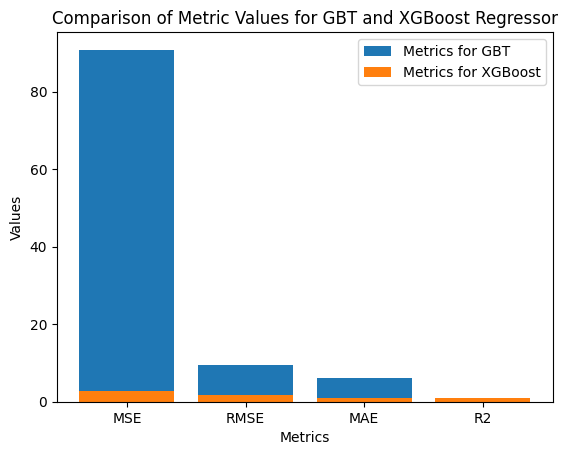

In [13]:
import matplotlib.pyplot as plt

# Actual values
gbt_values = [90.80037906839223, 9.528923290088562, 6.212597625372304, 0.635627492360588]

# Predicted values
xgboost_values = [mse, rmse, mae, r2]

# Create a bar plot
plt.bar(['MSE', 'RMSE', 'MAE', 'R2'], gbt_values, label='Metrics for GBT')
plt.bar(['MSE', 'RMSE', 'MAE', 'R2'], xgboost_values, label='Metrics for XGBoost')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Metric Values for GBT and XGBoost Regressor')

# Add legend
plt.legend()

# Show the plot
plt.show()
